# Deep Learning with ResNet50 on HAM10000 Skin data

## Libraries and Packages 

In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import shuffle, resample
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Data Preparation

In [ ]:
# Define the paths to the data
# Download data from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data
# You should have an archive folder with the two images directories and a metadata csv file
data_path = Path('/data/archive/')
csv_path = data_path / 'HAM10000_metadata.csv'

# Load the data
df_data = pd.read_csv(csv_path)

# Make diagnosis categorical and add a new column for numerical diagnosis
df_data.dx = df_data.dx.astype('category')
df_data['labels'] = df_data.dx.cat.codes

# Add the path to images to the dataframe
imageid_path_dict = {str(x).split('/')[-1][:-4]: str(x) for x in list(data_path.glob('*/*.jpg'))}
df_data['path'] = df_data['image_id'].map(imageid_path_dict)

NameError: name 'Path' is not defined

In [3]:
# Check for duplicate images for the same lesion_id
def check_duplicates(df, col):
    unique_list = df[col].unique().tolist()
    duplicates_count = len(df) - len(unique_list)
    return duplicates_count
    
duplicates_count = check_duplicates(df_data, 'lesion_id')
print(f'{duplicates_count} duplicates out of {len(df_data)}')

2545 duplicates out of 10015


# Baseline Model

## Split into training, validation, test

In [5]:
# Remove all duplicated lesion id's first and add them after splitting to only the training set

# Identify lesion_ids that are duplicated
duplicate_lesions = df_data['lesion_id'][df_data['lesion_id'].duplicated()].unique()

# Filter out duplicate lesion_ids by selecting only the first occurrence
# First, we create a new DataFrame with one image per lesion_id
unique_lesions_df = df_data[~df_data['lesion_id'].isin(duplicate_lesions)]
# unique_lesions_df = df_data[df_data['lesion_id'].duplicated(keep=False) == False]

# Split the data into training, validation, and test sets
# Split the data into train and temporary data (for validation and test)
train_data, temp_data = train_test_split(
    unique_lesions_df, stratify=unique_lesions_df['dx'], test_size=0.6, random_state=42
)
# Split the temporary data into validation and test sets
val_df, test_df = train_test_split(
    temp_data, stratify=temp_data['dx'], test_size=0.5, random_state=42
)

# Add the removed duplicates to the training set
# Get the duplicates that we filtered out
duplicate_lesions_df = df_data[df_data['lesion_id'].isin(duplicate_lesions)]
# Add the duplicates to the training set
train_df = pd.concat([train_data, duplicate_lesions_df])

# Print the sizes of the final splits
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")


Train set: 6706
Validation set: 1654
Test set: 1655


<Axes: xlabel='labels'>

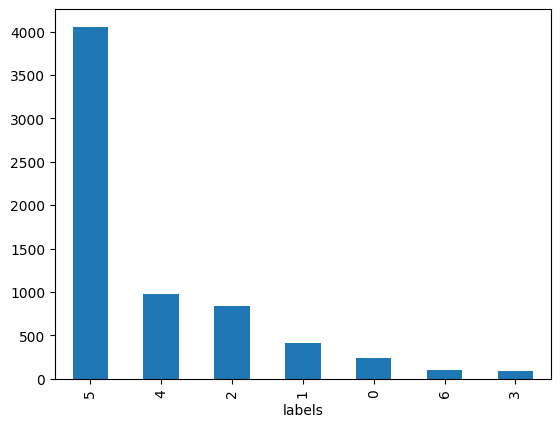

In [6]:
train_df['labels'].value_counts().plot(kind='bar')

## Prepare data generators

In [7]:
# No data augmentation for validation and test set
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators for each set using the .flow_from_dataframe() method
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 6706 validated image filenames belonging to 7 classes.
Found 1654 validated image filenames belonging to 7 classes.
Found 1655 validated image filenames belonging to 7 classes.


## Early stopping

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

## ResNet50 Baseline Model

In [ ]:
resnet50_model = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3)
)

resnet50_model.trainable = False

# Decoder to get the class probabilities
x = resnet50_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

baseline_model = Model(inputs=resnet50_model.input, outputs=predictions)

baseline_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
baseline_history = baseline_model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    callbacks = [early_stopping]
)

## Evaluation

In [ ]:
# Plot accuracy and loss curves
def show_history(history):
    plt.figure(figsize=(20,6))

    # Summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # Summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

show_history(baseline_history)

In [ ]:
# Confusion Matrix

# # Predict on the validation set
y_true = test_generator.classes
y_pred = baseline_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix Baseline Model')
#plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Baseline Model Normalized Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_classes))

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = baseline_model.evaluate(test_generator, steps=len(test_generator))

print(f"Baseline Model Test Loss: {test_loss}")
print(f"Baseline Model Test Accuracy: {test_accuracy}")

# Partially Balanced

## Split into training, validation, test

In [13]:
# Remove all duplicated lesion id's first and add them after splitting to only the training set

# Identify lesion_ids that are duplicated
duplicate_lesions = df_data['lesion_id'][df_data['lesion_id'].duplicated()].unique()

# Filter out duplicate lesion_ids
unique_lesions_df = df_data[~df_data['lesion_id'].isin(duplicate_lesions)]
# unique_lesions_df = df_data[df_data['lesion_id'].duplicated(keep=False) == False]

# Split the data into training, validation, and test sets
# Split the data into train and temporary data (for validation and test)
train_data, temp_data = train_test_split(
    unique_lesions_df, stratify=unique_lesions_df['dx'], test_size=0.4, random_state=42
)
# Split the temporary data into validation and test sets
val_df, test_df = train_test_split(
    temp_data, stratify=temp_data['dx'], test_size=0.5, random_state=42
)

# Add the removed duplicates to the training set
# Get the duplicates that we filtered out
duplicate_lesions_df = df_data[df_data['lesion_id'].isin(duplicate_lesions)]
# Add the duplicates to the training set
train_df = pd.concat([train_data, duplicate_lesions_df])

# Print the sizes of the final splits
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")


Train set: 7809
Validation set: 1103
Test set: 1103


## Balance by reducing only the size of the biggest class

In [14]:
# Keep only 1/5th of the images from the majority class in the training set
majority_class = train_df['labels'].value_counts().idxmax()
majority_class_count = train_df['labels'].value_counts()[majority_class]
target_count = majority_class_count / 5

majority_class_subset = train_df[train_df['labels'] == majority_class].sample(
    n=int(target_count), random_state=42
)
other_classes_subset = train_df[train_df['labels'] != majority_class]

train_df_balanced = pd.concat([majority_class_subset, other_classes_subset])

# Shuffle
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
# Print the sizes of the final splits
print(f"Train set: {len(train_df_balanced)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Train set: 3857
Validation set: 1103
Test set: 1103


<Axes: xlabel='labels'>

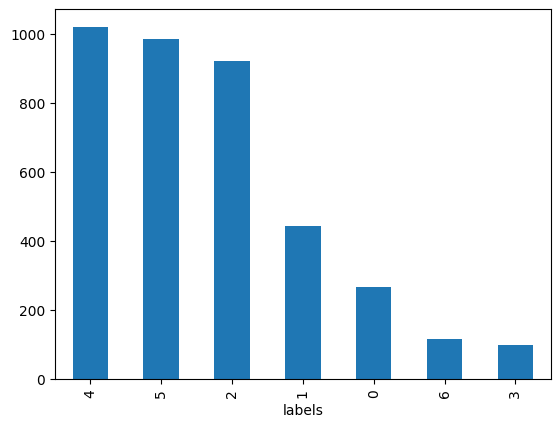

In [16]:
train_df_balanced['labels'].value_counts().plot(kind='bar')

## Prepare data generators

In [17]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest'
)
# No data augmentation for validation and test set
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Create generators for each set using the .flow_from_dataframe() method
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df_balanced,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224), # Resize images to 224x224 (ResNet input size)
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 3857 validated image filenames belonging to 7 classes.
Found 1103 validated image filenames belonging to 7 classes.
Found 1103 validated image filenames belonging to 7 classes.


## Create model

In [ ]:
# Instantiate base model with pre-trained weights
base_model = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Create decoder on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Calculating class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_balanced['dx']),
    y=train_df_balanced['dx']
)
class_weights = dict(enumerate(class_weights))

## Train model

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    start_from_epoch=10,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    class_weight = class_weights,
    callbacks = [early_stopping]
)

## Finetuning

In [ ]:
for layer in base_model.layers:
    if "conv5" in layer.name or "bn5" in layer.name:
        layer.trainable = True

model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    class_weight = class_weights,
    callbacks = [early_stopping],
)

## Evaluation

In [ ]:
def show_history(history):
    plt.figure(figsize=(20,6))

    # Summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Partially Balanced Model Accuracy After Fine-Tuning')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Partially Balanced Model Loss After Fine-Tuning')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()

show_history(history)

In [ ]:
# Predict on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Completely Balanced Test Normalized Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(y_true, y_pred_classes))

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Completely Balanced

## Split into training, validation and test sets

In [ ]:
# Remove all duplicated lesion id's first and add them after splitting to only the training set

# Identify lesion_ids that are duplicated
duplicate_lesions = df_data['lesion_id'][df_data['lesion_id'].duplicated()].unique()

# Filter out duplicate lesion_ids
unique_lesions_df = df_data[~df_data['lesion_id'].isin(duplicate_lesions)]
# unique_lesions_df = df_data[df_data['lesion_id'].duplicated(keep=False) == False]

# Split the data into training, validation, and test sets
# Split the data into train and temporary data (for validation and test)
train_data, temp_data = train_test_split(
    unique_lesions_df, stratify=unique_lesions_df['dx'], test_size=0.4, random_state=42
)
# Split the temporary data into validation and test sets
val_df, test_df = train_test_split(
    temp_data, stratify=temp_data['dx'], test_size=0.5, random_state=42
)

# Add the removed duplicates to the training set
# Get the duplicates that we filtered out
duplicate_lesions_df = df_data[df_data['lesion_id'].isin(duplicate_lesions)]
# Add the duplicates to the training set
train_df = pd.concat([train_data, duplicate_lesions_df])

# Print the sizes of the final splits
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")


In [ ]:
train_df['labels'].value_counts().plot(kind='bar')

## Balance by reducing all classes to the same size

In [ ]:
print(train_df['dx'].value_counts())
print(val_df['dx'].value_counts())
print(test_df['dx'].value_counts())


In [ ]:
# Downsample all classes to 70 samples each
def downsample_dataframe(dataframe, target_column='dx', n_samples=50):
    # Separate each class
    classes = dataframe[target_column].unique()
    class_dfs = [dataframe[dataframe[target_column] == cls] for cls in classes]

    # Downsample each class to n_samples
    downsampled_dfs = [
        resample(cls_df, replace=False, n_samples=n_samples, random_state=42)
        for cls_df in class_dfs
    ]

    # Combine back into a single dataframe
    downsampled_dataframe = pd.concat(downsampled_dfs, axis=0).sample(frac=1, random_state=42)  # Shuffle
    return downsampled_dataframe

# Downsample the training dataset
train_df_balanced = downsample_dataframe(train_df, target_column='dx', n_samples=99)
print("Class distribution after downsampling:")
print(train_df_balanced['dx'].value_counts())


In [ ]:
train_df_balanced['dx'].value_counts().plot(kind='bar')

## Prepare data generators

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest'
)
# No data augmentation for validation and test set
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Create generators for each set using the .flow_from_dataframe() method
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df_balanced,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'path',
    y_col = 'dx',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

## Create model

In [ ]:
# Instantiate base model with pre-trained weights
resnet50_model = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3)
)

# Freeze base model
resnet50_model.trainable = False

# Create decoder on top of the base model
x = resnet50_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(128)(x)
#x = LeakyReLU(alpha=0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=resnet50_model.input, outputs=predictions)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

#model.summary()

## Calculating class weights

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_balanced['dx']),
    y=train_df_balanced['dx']
)
class_weights = dict(enumerate(class_weights))

## Early stopping

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

## Train model

In [ ]:
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    callbacks = [early_stopping],
    class_weight = class_weights
)

## Fine-tuning

In [ ]:
# Optionally unfreeze specific layers
for layer in resnet50_model.layers:
    if "conv5" in layer.name or "bn5" in layer.name:
        layer.trainable = True

model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    callbacks = [early_stopping],
    class_weight = class_weights
)

## Evaluate model

In [ ]:
# Plot accuracy and loss curves
def show_history(history):
    plt.figure(figsize=(20,6))

    # Summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Completely Balanced Model Accuracy After Fine-Tuning')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Completely Balanced Model Loss After Fine-Tuning')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()

show_history(history)

In [ ]:
# Predict on the test set
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Completely Balanced Test Normalized Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(y_true, y_pred_classes))

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")